# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn
import imblearn

#  Etude des données

In [2]:
#On stock les données du CSV dans un dataframe
df=pd.read_csv("./balance_scale.csv")

In [3]:
#On regarde notre dataframe
df

,leftweight,leftdistance,rightweight,rightdistance,class
0,1,1,1,1,B
1,1,1,1,2,R
2,1,1,1,3,R
3,1,1,1,4,R
4,1,1,1,5,R
...,...,...,...,...,...
620,5,5,5,1,L
621,5,5,5,2,L
622,5,5,5,3,L
623,5,5,5,4,L


Ce data set représente les informations d'une balance et son équilibrage.<br/><br/>
Il y a 4 features:
<ul>
    <li>Leftweight: Le poids sur le côté gauche de la balance</li>
    <li>Rightweight: Le poids sur le côté droit de la balance</li>
    <li>Leftdistance: La distance du positionnement du poids sur la partie gauche</li>
    <li>Rightdistance: La distance du positionnement du poids sur la partie droite</li></ul>
<br/>
La target représente de quel côté penche la balance et comporte 3 classes: <br/>
    <ul>
        <li>R: La balance penche à Droite</li>
        <li>L: La balance penche à Gauche</li>
        <li>B: La balance est équilibrée</li></ul>

In [97]:
df.info() #On vérifie notre DataFrame pour voir si il est propre.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   leftweight     625 non-null    int64 
 1   leftdistance   625 non-null    int64 
 2   rightweight    625 non-null    int64 
 3   rightdistance  625 non-null    int64 
 4   class          625 non-null    object
dtypes: int64(4), object(1)
memory usage: 24.5+ KB


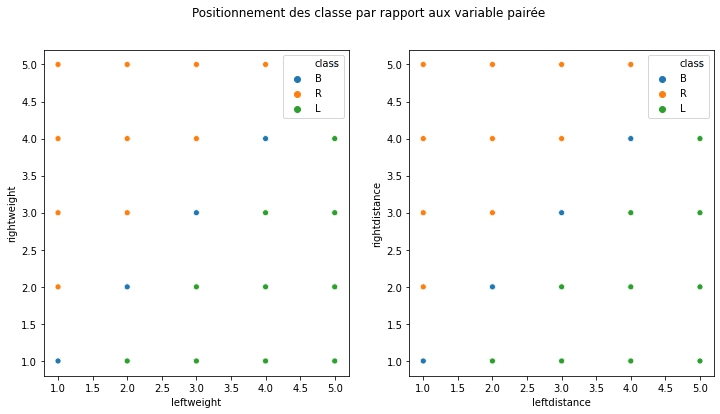

In [140]:
plt.figure(figsize=(12,6))
plt.suptitle("Positionnement des classe par rapport aux variable pairée")
plt.subplot(1,2,1)
sns.scatterplot(df.iloc[:,0],df.iloc[:,2], hue=df['class'])

plt.subplot(1,2,2)
sns.scatterplot(df.iloc[:,1],df.iloc[:,3], hue=df['class'])

<b> Le résultat est logique avec notre étude. </b> 

<b> Etudions la répartition des classes dans notre dataset </b>

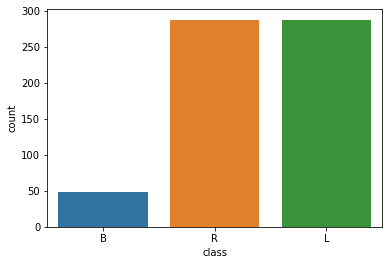

In [74]:
sns.countplot(df['class'])

<b> On remarque que la catégorie B est sous représenté il faudra peut-être devrons nous modifié celà si ça implique une baisse de qualité du modèle.</b>

# Logistic Regression without changing anything.

<b>On commence simplement avec un modèle de classification simple pour voir si ce déséquilibre impact nos modèles.</b>

In [141]:
#On importe notre algo de split et notre model Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [148]:
#On stock nos données de split dans 4 variable pour les utilisé plus tard.
data_Tr, data_Te, target_Tr, target_Te = train_test_split(df.iloc[:,0:4], df["class"]
                                 , random_state=16
                                 , train_size=0.75)

In [149]:
data_Tr

,leftweight,leftdistance,rightweight,rightdistance
340,3,4,4,1
50,1,3,1,1
328,3,4,1,4
298,3,2,5,4
375,4,1,1,1
...,...,...,...,...
452,4,4,1,3
321,3,3,5,2
581,5,4,2,2
121,1,5,5,2


In [169]:
lr=LogisticRegression(random_state=16)
lr.fit(data_Tr,target_Tr)

LogisticRegression(random_state=16)

In [170]:
result=lr.predict(data_Te)

In [171]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [172]:
accuracy=accuracy_score(result, target_Te)
recall= recall_score(result, target_Te, average=None)
precision= precision_score(result, target_Te, average=None)
F1= f1_score(result, target_Te, average=None)
#100 % avec 80 / 20 j'ai testé 50 / 50 pour tester j'obtiens 0.93

print("R =", recall) # précision de prédiction des valeur Positive correctement prédit
#par rapport à l'ensemble des vrais valeurs
print("A =", accuracy) # Précision sur l'ensemble des bon résultat (True positive and True neg) par rapport
#A l'ensmble des valeurs.
print("P =", precision)# Précision de prédiction des valeurs Positive par rapport à tout les donnée prédite 
#postif. 
print('F1 =', F1) #Valeur qui fait la balance entre recall et precision pour avoir une valeur qui maximise les 
#deux valeurs

R = [0.25       0.82758621 0.93939394]
A = 0.8598726114649682
P = [0.1        0.93506494 0.88571429]
F1 = [0.14285714 0.87804878 0.91176471]


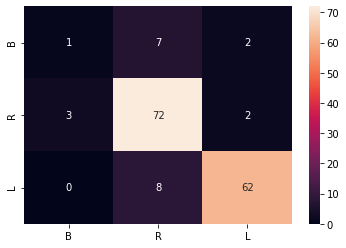

In [173]:
conf= confusion_matrix(target_Te, result)
sns.heatmap(conf, annot=True, xticklabels= df["class"].unique(),yticklabels= df["class"].unique())

<b>Si on ne regarde que l'accuracy_score on pourrait pensé que notre modèle est efficace cependant si on regarde les autres indicateurs on remarque que le Recall de la catégorie B est vraiment très bas ce qui indique un problème. </b><br/><br/>
<b>La matrice de confusion nous confirme ce constat le modèle compte tenu de la faible représentation de la catégorie B le modèle l'ignore presque dans ces pronostiques </b>
<br/><br/>
<b>Par conséquent nous allons essayer plusieurs méthodes pour équilibré notre dataset et fit à nouveau notre modèle</b>

# Logistique Regression avec du ressampling

## Resampling With smote.

<b> Notre jeu de donnée étant petit le réduire encore ne semble pas pertinent essayons donc de resample avec la fonction smote !</b>

In [111]:
from imblearn.over_sampling import SMOTE

In [174]:
#On utilise le smote qui va créer de nouvelle donnée avec un système de plus proche voisin
# Deux points de la même classe proche : O----O
# On va créer un nouveau point imaginaire entre ces deux points
# Création d'un nouveau point (x) entre nos deux précédents points: O--x--O
#Et ainsi de suite jusqu'à équilibrage
smote= SMOTE("minority")# Minority est un paramètre qui permet de n'augmenter que la classe minoritaire. 

smoted_df, y = smote.fit_sample(df.iloc[:,:4],df['class'])

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


In [175]:
#On stock notre target dans le df
smoted_df['target']=y

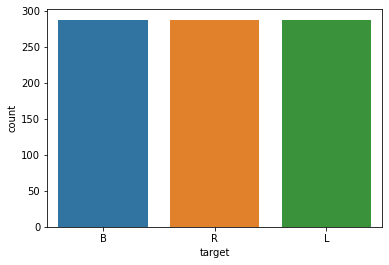

In [176]:
sns.countplot(smoted_df['target'])

<b> Nos données ont maintenant étaient équilibré recommençons notre modèle. </b>

In [206]:
data_Trs, data_Tes, target_Trs, target_Tes = train_test_split(smoted_df.iloc[:,0:4], smoted_df["target"]
                                 , random_state=16
                                 , train_size=0.75)

In [207]:
lr.fit(data_Trs,target_Trs)
results=lr.predict(data_Tes)

In [208]:
accuracys=accuracy_score(results, target_Tes)
recalls= recall_score(results, target_Tes, average=None)
precisions= precision_score(results, target_Tes, average=None)
F1s= f1_score(results, target_Tes, average=None)
#100 % avec 80 / 20 j'ai testé 50 / 50 pour tester j'obtiens 0.93

print("R =", recall) # précision de prédiction des valeur Positive correctement prédit
#par rapport à l'ensemble des vrais valeurs
print("A =", accuracy) # Précision sur l'ensemble des bon résultat (True positive and True neg) par rapport
#A l'ensmble des valeurs.
print("P =", precision)# Précision de prédiction des valeurs Positive par rapport à tout les donnée prédite 
#postif. 
print('F1 =', F1) #Valeur qui fait la balance entre recall et precision pour avoir une valeur qui maximise les 
#deux valeurs

R = [0.86666667 0.93421053 0.87692308]
A = 0.8935185185185185
P = [0.84415584 0.93421053 0.9047619 ]
F1 = [0.85526316 0.93421053 0.890625  ]


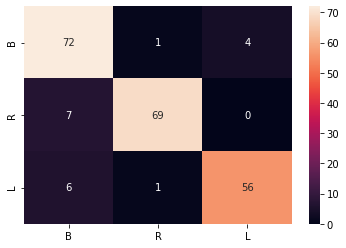

In [209]:
confs= confusion_matrix(target_Tes, results)
sns.heatmap(confs, annot=True, xticklabels= df["class"].unique(),yticklabels= df["class"].unique())

<b> Notre accuracy a augmenter et surtout le score de Recall et de précision est franchement à la hausse !</b> 

## Ressampling with Under_sampling

<b> Dans le doute tentons le ressampling avec une méthode de réduction</b>

In [210]:
from imblearn.under_sampling import RandomUnderSampler

In [211]:
#On utilise un algorithme RandomUnderSampler qui va réduire les samples des groupes majoritaires de manière aléatoire
#Il existe d'autre méthode comme le Tomek Link et le centroide. 

rus = RandomUnderSampler()
X_reduce, y_rus = rus.fit_sample(df.iloc[:,:4],df['class'])
X_reduce['target']=y_rus

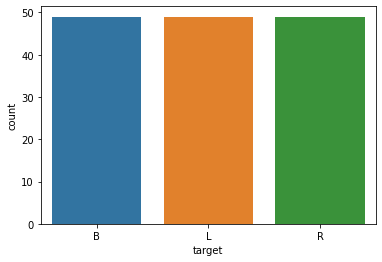

In [212]:
sns.countplot(X_reduce['target'])

In [213]:
data_Tru, data_Teu, target_Tru, target_Teu = train_test_split(X_reduce.iloc[:,0:4], X_reduce["target"]
                                 , random_state=16
                                 , train_size=0.75)

In [214]:
lr.fit(data_Tru,target_Tru)
resultu=lr.predict(data_Teu)

In [215]:
accuracyu=accuracy_score(resultu, target_Teu)
recallu= recall_score(resultu, target_Teu, average=None)
precisionu= precision_score(resultu, target_Teu, average=None)
F1u= f1_score(resultu, target_Teu, average=None)
#100 % avec 80 / 20 j'ai testé 50 / 50 pour tester j'obtiens 0.93

print("R =", recall) # précision de prédiction des valeur Positive correctement prédit
#par rapport à l'ensemble des vrais valeurs
print("A =", accuracy) # Précision sur l'ensemble des bon résultat (True positive and True neg) par rapport
#A l'ensmble des valeurs.
print("P =", precision)# Précision de prédiction des valeurs Positive par rapport à tout les donnée prédite 
#postif. 
print('F1 =', F1) #Valeur qui fait la balance entre recall et precision pour avoir une valeur qui maximise les 
#deux valeurs

R = [0.86666667 0.93421053 0.87692308]
A = 0.8935185185185185
P = [0.84415584 0.93421053 0.9047619 ]
F1 = [0.85526316 0.93421053 0.890625  ]


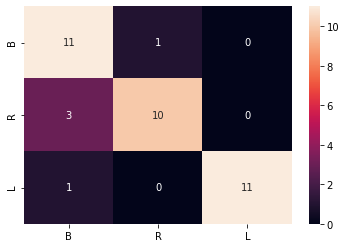

In [216]:
conf= confusion_matrix(target_Teu, resultu)
sns.heatmap(conf, annot=True, xticklabels= df["class"].unique(),yticklabels= df["class"].unique())

<b>On obtiens un resultat similaire voir meilleurs qu'avec le SMOTE cependant avec aussi peu de donnée le risque d'overtraining est réel...</b>

## Ressample Mixte !

In [217]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek('auto')
X_smt, y_smt = smt.fit_sample(df.iloc[:,:4],df['class'])

X_smt['target']=y_smt

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=auto as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


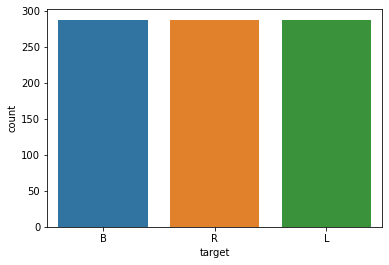

In [218]:
sns.countplot(X_smt['target'])

In [219]:
data_Trmix, data_Temix, target_Trmix, target_Temix = train_test_split(X_smt.iloc[:,0:4], X_smt["target"]
                                 , random_state=16
                                 , train_size=0.75)

In [220]:
lr.fit(data_Trmix,target_Trmix)
resultmix=lr.predict(data_Temix)

In [221]:
accuracymix=accuracy_score(resultmix, target_Temix)
recallmix= recall_score(resultmix, target_Temix, average=None)
precisionmix= precision_score(resultmix, target_Temix, average=None)
F1mix= f1_score(resultmix, target_Temix, average=None)
#100 % avec 80 / 20 j'ai testé 50 / 50 pour tester j'obtiens 0.93

print("R =", recall) # précision de prédiction des valeur Positive correctement prédit
#par rapport à l'ensemble des vrais valeurs
print("A =", accuracy) # Précision sur l'ensemble des bon résultat (True positive and True neg) par rapport
#A l'ensmble des valeurs.
print("P =", precision)# Précision de prédiction des valeurs Positive par rapport à tout les donnée prédite 
#postif. 
print('F1 =', F1) #Valeur qui fait la balance entre recall et precision pour avoir une valeur qui maximise les 
#deux valeurs

R = [0.86666667 0.93421053 0.87692308]
A = 0.8935185185185185
P = [0.84415584 0.93421053 0.9047619 ]
F1 = [0.85526316 0.93421053 0.890625  ]


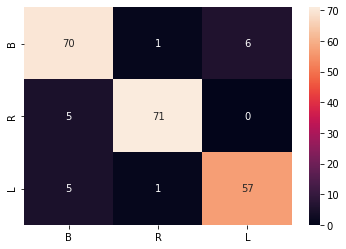

In [222]:
conf= confusion_matrix(target_Temix, resultmix)
sns.heatmap(conf, annot=True, xticklabels= df["class"].unique(),yticklabels= df["class"].unique())

<b> C'est pas franchement concluant </b>

<b>Conclusion: On voit clairement l'avantage de ressample nos données dans le cas d'un dataframe déséquilibré</b> 

#  Etude Select K Best 

<b> Select K Best est une fonction qui permet de visualiser quels features sont les meilleurs. Etudions donc comment cette fonction marche.</b>

In [229]:
from sklearn.feature_selection import SelectKBest

In [244]:
skb= SelectKBest(k=2)
dfskb= skb.fit_transform(df.iloc[:,:4],df['class'])

<b> Le Select K Best permet par le biais d'un score de faire une décision sur les features les plus importante dans le cas d'une classification ou d'une regression.<br/>

Il prend en paramètre deux grands types:
    <ul>
        <li> Le k est un indicateur qui permet de décidé du nombre de feature que l'on souhaite gardé </li>
        <li> Le score_func sur lequel on va spécifié avec quel métrics on va évalué nos features</li></ul>
De base le score_func utilise un anova pour évaluer mais on peut changer celà. </b>

In [250]:
dfskb[:10]

array([[1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [2, 5]], dtype=int64)

In [249]:
df[:10]

,leftweight,leftdistance,rightweight,rightdistance,class
0,1,1,1,1,B
1,1,1,1,2,R
2,1,1,1,3,R
3,1,1,1,4,R
4,1,1,1,5,R
5,1,1,2,1,R
6,1,1,2,2,R
7,1,1,2,3,R
8,1,1,2,4,R
9,1,1,2,5,R


In [251]:
dftwo=pd.DataFrame(dfskb, columns=['rightweight','rightdistance'])

In [254]:
dftwo['target']=df["class"]

In [255]:
dftwo

,rightweight,rightdistance,target
0,1,1,B
1,1,2,R
2,1,3,R
3,1,4,R
4,1,5,R
...,...,...,...
620,5,1,L
621,5,2,L
622,5,3,L
623,5,4,L


# Autre Modèle de classification

<b> On va maintenant testé avec trois autres modèle de classification : Decision Tree, Random Forest et XGboost. A chaque fois nous utiliserons deux jeux de donnée la version SMOTE et la version déséquilibré.</b>

## Decision Tree

### Unbalanced

In [258]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf= DecisionTreeClassifier(criterion="gini")

clf.fit(data_Tr, target_Tr)
result=clf.predict(data_Te)

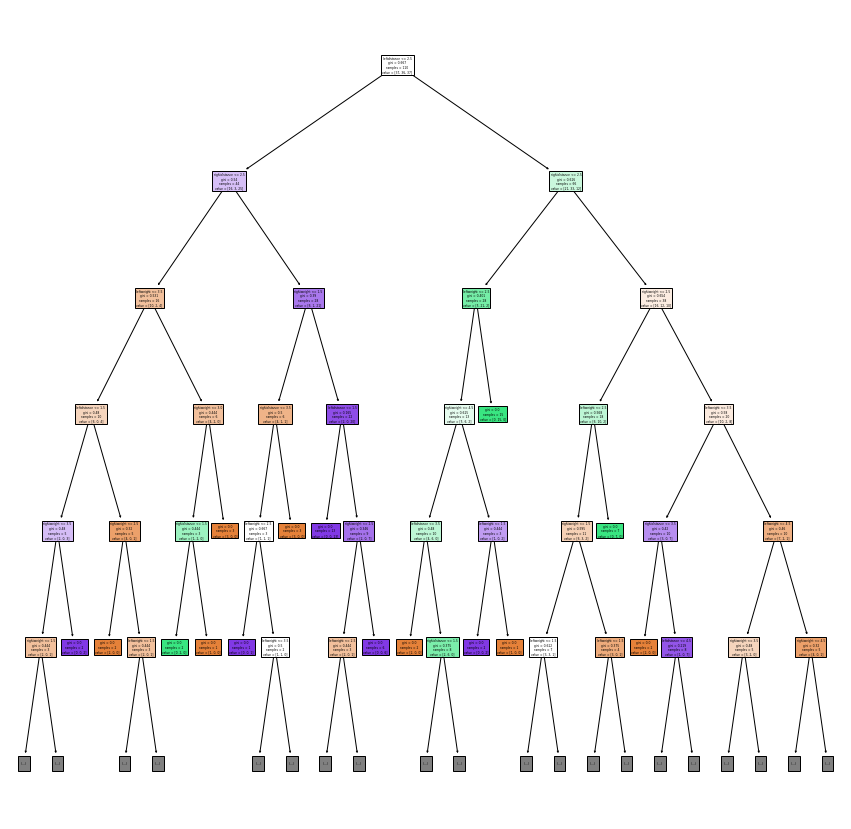

In [263]:
plt.figure(figsize=[15,15])
plot_tree(clf, filled= True, feature_names= data_Tr.iloc[:,0:4].columns, max_depth= 5)
plt.show()

###  Smoted Dataset

In [265]:
clf= DecisionTreeClassifier(criterion="gini")

clf.fit(data_Trs, target_Trs)
results=clf.predict(data_Tes)

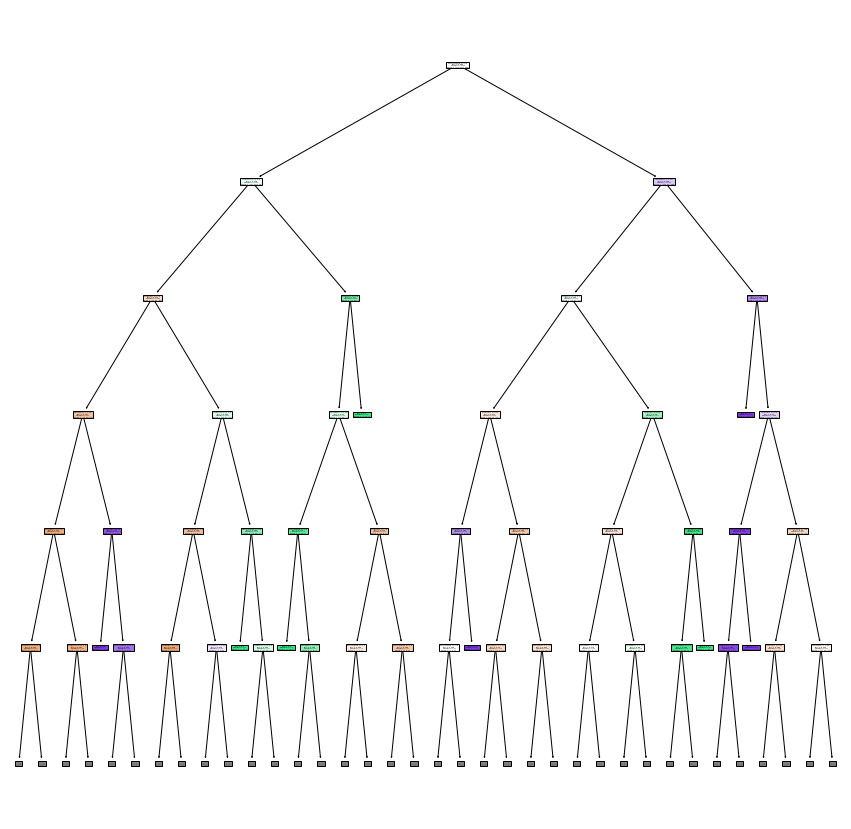

In [267]:
plt.figure(figsize=[15,15])
plot_tree(clf, filled= True, feature_names= data_Trs.iloc[:,0:4].columns, max_depth= 5)
plt.show()

### Résultats

In [272]:
acc=accuracy_score(result, target_Te)
accuracys=accuracy_score(results, target_Tes)
rec=recall_score(result, target_Te, average=None)
recalls= recall_score(results, target_Tes, average=None)
pre= precision_score(result, target_Te, average=None)
precisions= precision_score(results, target_Tes, average=None)
F1= f1_score(result, target_Te, average=None)
F1s= f1_score(results, target_Tes, average=None)

In [338]:
print("Accuracy :\n<",acc,"Avec dataset de base. \n", accuracys," SMOTED.")
print("Recall :\n",rec,"Avec dataset de base.\n ", recalls," SMOTED.")
print("Precision :\n",pre,"Avec dataset de base. \n", precisions," SMOTED.")
print("F1 :\n",F1,"Avec dataset de base.\n ", F1s," SMOTED.")

Accuracy :
< 0.8662420382165605 Avec dataset de base. 
 0.8888888888888888  SMOTED.
Recall :
 [0.09090909 0.94736842 0.9       ] Avec dataset de base.
  [0.79347826 0.98461538 0.93220339]  SMOTED.
Precision :
 [0.1        0.93506494 0.9       ] Avec dataset de base. 
 [0.94805195 0.84210526 0.87301587]  SMOTED.
F1 :
 [0.0952381  0.94117647 0.9       ] Avec dataset de base.
  [0.86390533 0.90780142 0.90163934]  SMOTED.


## Random Forest

### Unchanged

In [334]:
from sklearn.ensemble import RandomForestClassifier

#Pour le random forest on spécifie que l'on souhaite utiliser qu'une partie de de nos data et que l'on souhaite
#Répéter l'arbre 200 fois. 
#Autrement les parametre sont de bases et ressemble beaucoup à ceux du decision Tree
rfc= RandomForestClassifier(bootstrap=True, n_estimators=200, max_samples=50)

rfc.fit(data_Tr, target_Tr)
result=clf.predict(data_Te)

In [287]:
feature_imp = pd.Series(rfc.feature_importances_,index=df.iloc[:,:4].columns).sort_values(ascending=False)
feature_imp

leftdistance     0.288924
rightdistance    0.251302
rightweight      0.247227
leftweight       0.212546
dtype: float64

Text(0.5, 1.0, "Visualisation de l'importance des features")

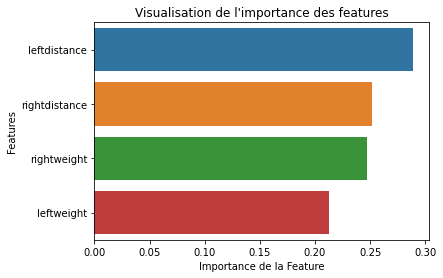

In [288]:
#Ce graph est intéressant car il permet de comparé avec K best
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel("Importance de la Feature")
plt.ylabel("Features")
plt.title("Visualisation de l'importance des features")

### Smote

In [289]:
rfc.fit(data_Trs, target_Trs)
results=clf.predict(data_Tes)

###  Résultat

In [290]:
acc=accuracy_score(result, target_Te)
accuracys=accuracy_score(results, target_Tes)
rec=recall_score(result, target_Te, average=None)
recalls= recall_score(results, target_Tes, average=None)
pre= precision_score(result, target_Te, average=None)
precisions= precision_score(results, target_Tes, average=None)
F1= f1_score(result, target_Te, average=None)
F1s= f1_score(results, target_Tes, average=None)

In [316]:
print("Accuracy :\n",acc,"Avec dataset de base. \n",
      accuracys,"SMOTED.")
print("Recall : \n",rec,"Avec dataset de base. \n", recalls," SMOTED.")
print("Precision :\n",pre,"Avec dataset de base. \n", precisions," SMOTED.")
print("F1 :\n",F1,"Avec dataset de base. \n", F1s," SMOTED.")

Accuracy :
 0.8918918918918919 Avec dataset de base. 
 0.8472222222222222 SMOTED.
Recall : 
 [0.78571429 1.         0.91666667] Avec dataset de base. 
 [0.73469388 0.98412698 0.89090909]  SMOTED.
Precision :
 [0.91666667 0.84615385 0.91666667] Avec dataset de base. 
 [0.93506494 0.81578947 0.77777778]  SMOTED.
F1 :
 [0.84615385 0.91666667 0.91666667] Avec dataset de base. 
 [0.82285714 0.89208633 0.83050847]  SMOTED.


## XGBOOST

### Unchanged

In [326]:
import xgboost as xgb


#Nos target doivent être en numérique je dois donc refaire mon split une fois mes target modifier dans mes 
#Deux dataframe
df["class"] = pd.Categorical(df['class'])
df['target']=df['class'].cat.codes
smoted_df['target']=pd.Categorical(smoted_df['target'])
smoted_df['target']=smoted_df['target'].cat.codes
#Le split des datas inchangé.

data_Tr, data_Te, target_Tr, target_Te = train_test_split(df.iloc[:,0:4], df["target"]
                                 , random_state=16
                                 , train_size=0.75)
#Le split des datas Smoted.

data_Trs, data_Tes, target_Trs, target_Tes = train_test_split(smoted_df.iloc[:,0:4], smoted_df["target"]
                                 , random_state=16
                                 , train_size=0.75)


#Unchanged
dtrain = xgb.DMatrix(data_Tr, label=target_Tr)
dtest = xgb.DMatrix(data_Te, label=target_Te)

#Smoted
dstrain=xgb.DMatrix(data_Trs, label=target_Trs)
dstest=xgb.DMatrix(data_Tes, label=target_Tes)

In [327]:
#On fixe nos différents paramètre de notre modèle XGboost
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 100

In [328]:
bst = xgb.train(param, dtrain, num_round)
bstsmote= xgb.train(param, dstrain, num_round)

[17:39:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:39:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [329]:
result = bst.predict(dtest)
results=bstsmote.predict(dstest)

In [330]:
len(result)
len(results)

216

In [332]:
acc=accuracy_score(result, target_Te)
accuracys=accuracy_score(results, target_Tes)
rec=recall_score(result, target_Te, average=None)
recalls= recall_score(results, target_Tes, average=None)
pre= precision_score(result, target_Te, average=None)
precisions= precision_score(results, target_Tes, average=None)
F1= f1_score(result, target_Te, average=None)
F1s= f1_score(results, target_Tes, average=None)

print("Accuracy :\n",acc,"Avec dataset de base. \n",
      accuracys,"SMOTED.")
print("Recall : \n",rec,"Avec dataset de base. \n", recalls," SMOTED.")
print("Precision :\n",pre,"Avec dataset de base. \n", precisions," SMOTED.")
print("F1 :\n",F1,"Avec dataset de base. \n", F1s," SMOTED.")


Accuracy :
 0.8662420382165605 Avec dataset de base. 
 0.8888888888888888 SMOTED.
Recall : 
 [0.09090909 0.94736842 0.9       ] Avec dataset de base. 
 [0.79347826 0.98461538 0.93220339]  SMOTED.
Precision :
 [0.1        0.93506494 0.9       ] Avec dataset de base. 
 [0.94805195 0.84210526 0.87301587]  SMOTED.
F1 :
 [0.0952381  0.94117647 0.9       ] Avec dataset de base. 
 [0.86390533 0.90780142 0.90163934]  SMOTED.


In [333]:
#Pas autant commenté comme voulu à la base mais j'essayerais d'y retourner dans le week-end... 
#J'ai posté mes deux notebook Decision Tree et Random Forest ou j'ai détaillé chacun des algorythmes
#Je fouille encore pour le XGboost. 